In [206]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("./paper.mplstyle")
from gol import DormantLife

# Extinction Times

In [191]:
def load_extinction_time_data(alpha, cleaned=True):
    base_path = "./data/dormant-life/extinction-time/"
    fname = f"alpha-p{str(alpha)[2:]}.dat"
    data = np.loadtxt(os.path.join(base_path, fname))
    if cleaned:
        return data[data>0]
    return data

def gen_normalized_histogram(data: np.array, bin_min: float, bin_max: float,
                            bin_number: int) -> tuple[np.array, np.array]:
    """
    Generate a normalized histogram from data. Returns tuple with lower
    bin bounds (suitable for bar plot with kw align: "edge") and
    respective probabilities.
    """
    bins = np.arange(bin_min, bin_max, bin_max / bin_number)
    counts, bin_edges = np.histogram(data, bins=bins)
    probs = counts / len(data)
    return bin_edges[:-1], probs

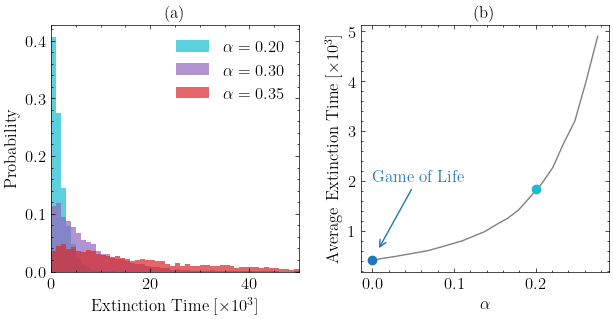

In [238]:
fig, (axl, axr) = plt.subplots(1, 2, figsize=(7.2, 3.2))
axl.set(xlabel=r"Extinction Time $\left[\times 10^3\right]$",
        ylabel="Probability",
        xlim=(0, 50),
        title="(a)")
bin_params = (bin_min, bin_max, bin_number) = (0, 100_000, 100)
alphas = [0.2, 0.3, 0.35]
color_cycle = ["tab:cyan", "tab:purple", "tab:red"]
for alpha, c in zip(alphas, color_cycle):
    data = load_extinction_time_data(alpha)
    bins, probs = gen_normalized_histogram(data, *bin_params)
    shrinked_bins = bins / 1000
    axl.bar(shrinked_bins, probs, width=shrinked_bins[1]-shrinked_bins[0],
            align="edge", alpha=.7, label=r"$\alpha = %.2f$"%alpha, color=c)
axl.legend()

axr.set(xlabel=r"$\alpha$",
        ylabel=r"Average Extinction Time $\left[\times 10^3\right]$",
        title="(b)")
alphas = np.loadtxt("./data/dormant-life/extinction-time/alpha-range.dat")
extinction_times = np.array([np.mean(load_extinction_time_data(alpha)) for alpha in alphas[:21]])/1000
axr.plot(alphas[:21], extinction_times, color="gray")
# Draw marker for Game of Life
axr.annotate("Game of Life", (0, extinction_times[0]), xytext=(0., 2),
            arrowprops={"arrowstyle":"->", "relpos":(0.5, 0.5),
                        "color":"tab:blue", "shrinkB":10},
            c="tab:blue")
axr.scatter(x=0, y=extinction_times[0], c="tab:blue", zorder=10)
# Mark alphas from axl
axr.scatter(x=0.2, y=extinction_times[15]-0.1, c="tab:cyan", zorder=10)

# Old

In [44]:
def DL_alive_cells(grid_size: int, runs: int, t_max: int,
                   alpha: float, base_seed: int = None) -> np.array:
    data = np.zeros((runs, t_max + 1))
    if base_seed is None:
        base_seed = np.random.randint(1)
    for i in range(runs):
        seed = base_seed + i
        rng = np.random.default_rng(seed)
        q = 0.37017384
        init_grid = rng.choice([0, 1], p=[1-q, q], size=[grid_size, grid_size])
        gol = DormantLife(init_grid)
        for j in range(t_max + 1):
            data[i, j] = gol.alive_count
            gol.step(alpha=alpha)
    return data

In [45]:
grid_size = 30
small_grid_size = 14
runs = 100
t_max = 5000
times = np.arange(t_max + 1)
base_seed = 100

In [46]:
data_1 = np.mean(DL_alive_cells(grid_size, runs, t_max, 1, base_seed), axis=0)
data_p75 = np.mean(DL_alive_cells(grid_size, runs, t_max, .75, base_seed), axis=0)
data_p5 = np.mean(DL_alive_cells(grid_size, runs, t_max, .5, base_seed), axis=0)
data_p35 = np.mean(DL_alive_cells(grid_size, runs, t_max, .35, base_seed), axis=0)
data_p25 = np.mean(DL_alive_cells(grid_size, runs, t_max, .25, base_seed), axis=0)
data_p1 = np.mean(DL_alive_cells(grid_size, runs, t_max, .1, base_seed), axis=0)
data_0 = np.mean(DL_alive_cells(grid_size, runs, t_max, 0, base_seed), axis=0)

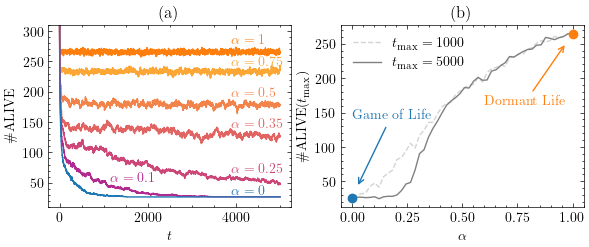

In [78]:
grid_size = 30
small_grid_size = 14
runs = 100
t_max = 5000
times = np.arange(t_max + 1)
base_seed = 100

alphas = [data_1,data_p75,data_p5,data_p35,data_p25,data_p1,data_0]
colors = ["tab:orange",
        *mpl.colormaps["plasma"](np.linspace(0.8, 0.4, 5)),
        "tab:blue"]
label_texts = [r"$\alpha = 1$", r"$\alpha = 0.75$", r"$\alpha = 0.5$",
                r"$\alpha = 0.35$", r"$\alpha = 0.25$", r"$\alpha = 0.1$",
                r"$\alpha = 0$"]
x_offsets = [0, 0, 0, 0, 0, -2750, 0]
y_offsets = [15, 2, 15, 15, 18, 25, 5]

def plot_time_series(ax, x, y, label_text, color, x_offset, y_offset):
    ax.plot(x, y, color=color)
    ax.text(x[-int(len(x)/4.5)]+x_offset, y[-1]+y_offset, label_text,
            color=color)

fig, (axl, axr) = plt.subplots(figsize=(6,3), ncols=2)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=None)
fig.tight_layout()
axl.set(title="(a)", box_aspect=3/4, ylim=(10,310))
axr.set(title="(b)", box_aspect=3/4)
axl.set(xlabel=r"$t$", ylabel=r"$\#\text{ALIVE}$")
for alpha, label_text, color, x_offset, y_offset in zip(alphas,
                                                        label_texts,
                                                        colors,
                                                        x_offsets,
                                                        y_offsets):
    data = alpha
    plot_time_series(axl, times, data, label_text, color, x_offset, y_offset)

alphas, N_alive_t_1000, N_alive_final = np.loadtxt("./data/phase_transition_2.dat")
axr.set(xlabel=r"$\alpha$", ylabel=r"$\#\text{ALIVE}(t_\text{max})$")
axr.plot(alphas, N_alive_t_1000, label=r"$t_\mathrm{max} = 1000$", color="lightgray", linestyle="--")
axr.plot(alphas, N_alive_final, label=r"$t_\mathrm{max} = 5000$", color="gray")
axr.annotate("Game of Life", (0, N_alive_final[0]), xytext=(0., 140),
            arrowprops={"arrowstyle":"->", "relpos":(0.5, 0.5),
                        "color":"tab:blue", "shrinkB":10},
            c="tab:blue")
axr.scatter(x=0, y=N_alive_final[0], c="tab:blue", zorder=10)
axr.annotate("Dormant Life", (1, N_alive_final[-1]), xytext=(.6, 160),
            arrowprops={"arrowstyle":"->", "relpos":(0.5, 0.5),
                        "color":"tab:orange", "shrinkB":10},
            c="tab:orange")
axr.scatter(x=1, y=N_alive_final[-1], c="tab:orange", zorder=10)
axr.legend()
fig.savefig("./img/phase_transition", dpi=500)

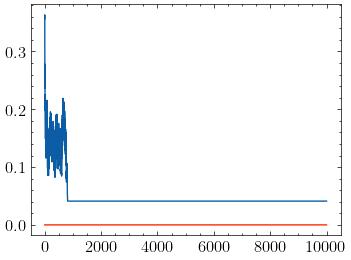

In [79]:
t_max = 10000
alpha = 0.25
N = 30
q = 0.37017384
init_grid = np.random.choice([0, 1], p=[1-q, q], size=[N, N])
gol = DormantLife(init_grid, alpha=alpha)
data = np.zeros(t_max)
while gol.t < t_max:
    data[gol.t] = gol.alive_count
    gol.step()
fig, ax = plt.subplots()
ax.plot(np.arange(t_max), data/N**2)
ax.plot(np.arange(t_max), [0]*t_max)
# ax.set(xlim=(8000,10000))